This notebook aims to explore capabilities of the NNs to predict density error based on the information about the <i> density field only</i>. They are compared with deterministic parametrization from the paper (Stanley et al 2020).

# Import

In [1]:
import glob, os
from IPython.display import clear_output
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm, trange
import xarray as xr
import dask
import pandas as pd
from IPython import display
from prettytable import PrettyTable
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint
import inspect
import tensorboard
from tensorboard.backend.event_processing.event_file_loader import EventFileLoader
import itertools

In [2]:
import logging
logging.getLogger('lightning').setLevel(0)
pl.utilities.distributed.log.setLevel(logging.ERROR)

In [3]:
import platform
print(platform.platform())

macOS-12.6-arm64-arm-64bit


In [395]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:49629")

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+-------------+-----------+-----------+----------+
| Package     | Client    | Scheduler | Workers  |
+-------------+-----------+-----------+----------+
| cloudpickle | 2.2.0     | 2.1.0     | 2.1.0    |
| dask        | 2022.05.0 | 2022.9.0  | 2022.9.0 |
| distributed | 2022.5.0  | 2022.9.0  | 2022.9.0 |
| numpy       | 1.23.3    | 1.23.2    | 1.23.2   |
| tornado     | 6.2       | 6.1       | 6.1      |
+-------------+-----------+-----------+----------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [4]:
#device = torch.device("mps")
device = torch.device("cpu")

In [474]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

# Data classes

The proposed implementation of the ``pytorch Dataset`` class reads netcdf files with data and can transform it for pytorch tensors. It allows to choose any number of netcdf files that will form the dataset and adjust the quantity of time snapshots taken from files. It also can perform normalization by mean and std of a variable in the file (so that the average is performed individually for each region and season). It is possible to create a dataset from 1 region and season, or to combine few one them (by combining files) and shuffle the snapshots in the training dataset.

In [239]:
features_to_add_to_sample = ['sigma0_model', 'sosstsst', 'sosaline', 'diff_S_sqr', 'diff_TS', 'rho_sa_sa', 'rho_sa_ct', 'diff_T_sqr', 'rho_ct_ct', 'sigma0_delta']

In [240]:
# coefficient c in the deterministic parametrization (the one that needs calibrated)
coef_determ_param = 0.27354727590256256

## Pytorch dataset

In [343]:
class SalinityTemperatureDensityDataset(torch.utils.data.Dataset):
    """Dataset of 2D maps of surface temperature, salinity"""

    def __init__(self, xarray_dataset, select='All', portion_of_time_series=0.5, transform=None):
        self.transform = transform
        #self.data = xr.open_dataset(netcdf_file)
        self.data = xarray_dataset
        self.data = self.data.bfill(dim='x').bfill(dim='y') # nan filling (the very draft version of nans treatment)
        if (np.isnan(self.data['diff_S_sqr']).any() or np.isnan(self.data['sigma0_delta']).any()) :
            print("WARNING: NANS in data " + netcdf_file)
        full_data_file_len = len(self.data['time_counter'])
        if (select == 'All') :
            time_index_range = np.arange(0, data_file_len)
        elif (select == 'First') :
            time_index_range = np.arange(0, int(portion_of_time_series*full_data_file_len)+1)
        elif (select == 'Last') :
            time_index_range = np.arange(int((1-portion_of_time_series)*full_data_file_len), full_data_file_len)
        self.data = self.data.isel(time_counter=time_index_range)
        self.data_file_len = len(self.data['time_counter'])
        # pre-compute some stuff fields (do it in xArray format, before transform to pytorch tensor)
        for feature in features_to_add_to_sample :
            self.data.attrs['mean_'+feature] = self.data.data_vars[feature].mean().compute()
            self.data.attrs['std_'+feature] = self.data.data_vars[feature].std().compute()
        
    def __len__(self):
        return self.data_file_len

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            list_idx = idx.tolist()
        else :
            list_idx = idx
        selected_time_frames = self.data.isel(time_counter=list_idx)
        
        # create dictionary of a sample (a batch) containig different features. 
        # This dictionary is sort of an intermediate step, preparing xArray data for trasform into pytorch tensors
        sample = dict()
        sample['dataset_region'] = self.data.attrs['region']
        sample['dataset_season'] = self.data.attrs['season']
        for key in keys_to_add_to_sample :
            sample[key] = selected_time_frames[key].values  # transform to a numpy array
            # mean and std of the FILE dataset (to avoid batch avg) for possible normalization
            sample['mean_'+key] = selected_time_frames.attrs['mean_'+key].values
            sample['std_'+key] = selected_time_frames.attrs['std_'+key].values
            sample['normalized_'+key] = ((selected_time_frames[key]-sample['mean_'+key])/sample['std_'+key]).values
        if self.transform:
            sample = self.transform(sample)
        sample['determ_param_sigma0_delta'] = SalinityTemperatureDensityDataset.deterministic_parametrization(sample, coef_determ_param)
        return sample
    
    def restore_units(tensor, sample, reference_feature) :
        return tensor*(sample['std_'+reference_feature].view(-1,1,1))+sample['mean_'+reference_feature].view(-1,1,1)
                
    def normalize(tensor, sample, reference_feature) :
        return (tensor-sample['mean_'+reference_feature].view(-1,1,1))/(sample['std_'+reference_feature].view(-1,1,1))
    
    def deterministic_parametrization(sample, calibration_coef) :
        return 0.5*calibration_coef*sample['diff_T_sqr']*sample['rho_ct_ct']

In [344]:
class ToTensor(object):
    """Convert each numpy array in sample to Tensors."""

    def __call__(self, sample):
        transformed_sample=sample.copy()
        for key in keys_to_add_to_sample :
            transformed_sample[key] = torch.from_numpy(sample[key].copy())
        return transformed_sample

In [345]:
xr_dataset0 = xr.open_dataset('datasets/dataset0.nc')

test_ds = SalinityTemperatureDensityDataset(xr_dataset0, select='Last', portion_of_time_series=0.6, transform=ToTensor())

test_dl = torch.utils.data.DataLoader(dataset=test_ds, batch_size=5, drop_last=True)

test_di = iter(test_dl)

sample = next(test_di)

sample['normalized_sigma0_delta'].shape

torch.Size([5, 24, 20])

In [346]:
restored = SalinityTemperatureDensityDataset.restore_units(sample['normalized_sigma0_delta'], sample, 'sigma0_delta')

In [347]:
normalized = SalinityTemperatureDensityDataset.normalize(restored, sample, 'sigma0_delta')

In [348]:
(sample['normalized_sigma0_delta'] - normalized).sum()

tensor(-1.6653e-15, dtype=torch.float64)

In [349]:
(sample['sigma0_delta'] - restored).sum()

tensor(-1.2902e-17, dtype=torch.float64)

In [350]:
sample['diff_T_sqr'].shape

torch.Size([5, 24, 20])

In [351]:
(coef_determ_param*sample['diff_T_sqr']*sample['rho_ct_ct']).shape

torch.Size([5, 24, 20])

## PyLi data module

A DataModule standardizes the training, val, test splits, data preparation and transforms. The main advantage is consistent data splits, data preparation and transforms across models.

In [652]:
from pytorch_lightning.trainer.supporters import CombinedLoader

class PyLiDataModule(pl.LightningDataModule):
    def __init__(self, list_of_dataset_files, batch_size):
        super().__init__()
        self.list_of_dataset_files = list_of_dataset_files
        self.batch_size = batch_size
    def prepare_data(self):
        self.list_of_xr_datasets = []
        for file in self.list_of_dataset_files :
            self.list_of_xr_datasets.append(xr.open_dataset(file,chunks='auto').load())  #REPLACE FOR CLOUD LOADING
    # def setup(self, stage):
    #     make assignments here (val/train/test split)
    #     called on every process in DDP
    def train_dataloader(self):
        # train_datasets = [SalinityTemperatureDensityDataset(xr_dataset, select='First', portion_of_time_series=0.6, transform=ToTensor()) \
        #                   for xr_dataset in self.list_of_xr_datasets]
        # return [torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, drop_last=True) for dataset in train_datasets]
        train_datasets = torch.utils.data.ConcatDataset([SalinityTemperatureDensityDataset(xr_dataset, select='First', portion_of_time_series=0.6, transform=ToTensor()) \
                           for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(train_datasets, batch_size=self.batch_size, shuffle=True, drop_last=True)
    def val_dataloader(self):
        val_datasets = torch.utils.data.ConcatDataset([SalinityTemperatureDensityDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets])
        return torch.utils.data.DataLoader(val_datasets, batch_size=self.batch_size, drop_last=True) 
    def test_dataloader(self):
        test_datasets = [SalinityTemperatureDensityDataset(xr_dataset, select='Last', portion_of_time_series=0.2, transform=ToTensor()) \
                          for xr_dataset in self.list_of_xr_datasets]
        return [torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True) for dataset in test_datasets]
    #def teardown(self):
        # clean up after fit or test
        # called on every process in DDP

# Data properties

In [653]:
list_of_datasets = sorted(glob.glob('datasets/dataset?.nc'))  # put correct path to netcdf files here
print(list_of_datasets)

['datasets/dataset0.nc', 'datasets/dataset1.nc', 'datasets/dataset2.nc', 'datasets/dataset3.nc', 'datasets/dataset4.nc', 'datasets/dataset5.nc']


In [654]:
h = 24 # height of images
w = 20 # width of images

In [655]:
common_datamodule = PyLiDataModule(list_of_datasets, batch_size=4)

# Useful functions

A function that counts the optimized parameters in a given model and prints it in a readable table form:

In [656]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

A function that allows to read the logs in tensorboars format and returns them as a python dictionary:

In [657]:
def get_logs_from_tb(exp_name, version_name, directory='logs/') :
    dictionary = dict()
    # for var in list_of_vars :
    #     dictionary[var] = list()
    for event in EventFileLoader(glob.glob(directory + '/' + exp_name + '/' + version_name + '/events.out.*')[0]).Load() :
        if (len(event.summary.value) > 0) :
            if (event.summary.value[0].tag not in dictionary) :
                dictionary[event.summary.value[0].tag] = []
            (dictionary[event.summary.value[0].tag]).append(event.summary.value[0].tensor.float_val)
    return dictionary

# Experiment class

This class collects all information needed for an experiment:

In [689]:
class Experiment :
    log_directory='logs/'
    
    def __init__(self, pl_class, model, label, version_name, datamodule, keys_input, keys_targets, max_epochs=None, limit_train_batches=1.0) :
        super().__init__()
        self.pl_class = pl_class  # pytorch lightning module class
        self.model = model
        self.label = label
        self.version_name = version_name
        self.datamodule = datamodule
        self.keys_input = keys_input
        self.keys_targets = keys_targets
        self.max_epochs = max_epochs
        self.limit_train_batches = limit_train_batches
        
    def run(self) :
        self.NN = self.pl_class(self.model, self.keys_input, self.keys_targets)
        self.logger = pl_loggers.TensorBoardLogger(save_dir=self.log_directory, name=self.label, version=self.version_name)
        self.checkpoint_callback = ModelCheckpoint(dirpath=self.log_directory + self.label + "/" + self.version_name, \
                                              save_top_k=2, monitor="loss_val")
    
        self.trainer = pl.Trainer(max_epochs=self.max_epochs, logger=self.logger, limit_train_batches=self.limit_train_batches, \
                                  callbacks=[EarlyStopping(monitor="loss_val", mode="min"), self.checkpoint_callback])  
        self.trainer.fit(model = self.NN, datamodule=self.datamodule)
        self.logs = get_logs_from_tb(exp_name=self.label, version_name=self.version_name, directory=self.log_directory)
        
    def test(self) :
        return self.trainer.test(self.NN, datamodule=self.datamodule)

# Fully-connected NN

Evaluation loss function:

In [691]:
eval_loss = torch.nn.MSELoss(reduction='none') 

The pytorch lightning class describing a model that treats the inputs/outputs pixel by pixel. 

In [692]:
class LitPixelModel(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        # initialization of model parameters with random numbers 
        # for name, param in nnModel.named_parameters():
        #     param.data.normal_(mean=0.0, std=0.1)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    # validation logics (is evaluated during the training, but the data is not used to the optimization loop)
    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    # gives model output in a form of a dictionary of 2d variables
    def predict_step(self, batch, batch_idx, dataloader_idx) :
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = tensor_model_output[:,i].view(-1,h,w)
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    # testing logic - to evaluate the model after training
    def test_step(self, batch, batch_idx, dataloader_idx) :
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict()
        
        for i, feature in enumerate(self.outputs) : 
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                loss[not_normalized_feature] = eval_loss(model_output[not_normalized_feature], batch[not_normalized_feature])
                self.log('loss_test_'+not_normalized_feature, loss[not_normalized_feature].mean())
            loss[feature] = eval_loss(model_output[feature], batch[feature])
            self.log('loss_test_'+feature, loss[feature].mean())

    def configure_optimizers(self) :
        #optimizer = optim.Adam(self.parameters(), lr=1e-3)
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer
    
    def transform_input(self, batch) :
        # since the data is treated pixel-by-pixel, the actual batch for training will actually consist of all points of all batches. 
        # this part flattens the 2d maps of different variables 
        transform = torch.hstack([batch[key].view(-1,1) for key in self.inputs]).to(torch.float32)
        return transform
    
    def transform_target(self, batch) : 
        return torch.hstack([batch[key].view(-1,1) for key in self.outputs]).to(torch.float32)

## Experiment 0

In [693]:
# layer4_FCNN_model = torch.nn.Sequential(torch.nn.Linear(6, 8), \
#                                        torch.nn.ReLU(), \
#                                        torch.nn.Linear(8, 16), \
#                                        torch.nn.ReLU(), \
#                                        torch.nn.Linear(16, 8), \
#                                        torch.nn.ReLU(), \
#                                        torch.nn.Linear(8, 1))

In [694]:
class FCNN(torch.nn.Module):
    def __init__(self, len_keys_input_FCNN, len_keys_targets_FCNN):
        super().__init__()
        self.lin1 = torch.nn.Linear(len_keys_input_FCNN, 8)
        self.lin2 = torch.nn.Linear(8, 16)
        self.lin3 = torch.nn.Linear(16, 8)
        self.lin4 = torch.nn.Linear(8, len_keys_targets_FCNN)

    def forward(self, x):
        #flatten_input = nn.Flatten(x)
        res = self.lin1(x)
        res = torch.nn.functional.relu(res)
        res = self.lin2(res)
        res = torch.nn.functional.relu(res)
        res = self.lin3(res)
        res = torch.nn.functional.relu(res)
        res = self.lin4(res)
        return res

In [695]:
layer4_FCNN_model = FCNN(6,1)

In [696]:
exp0 = Experiment(pl_class=LitPixelModel, \
                      model=FCNN(6,1), \
                      label='4_layers', \
                      version_name='version_0', \
                      keys_input={'normalized_diff_S_sqr', 'normalized_diff_TS', 'normalized_rho_sa_sa', \
                                  'normalized_rho_sa_ct', 'normalized_diff_T_sqr', 'normalized_rho_ct_ct'}, \
                      keys_targets={'normalized_sigma0_delta'}, 
                      datamodule=common_datamodule,\
                      max_epochs=5, \
                      limit_train_batches=1.0) 

In [697]:
exp0.run()
clear_output(wait=True)


  | Name    | Type | Params
---------------------------------
0 | nnModel | FCNN | 345   
---------------------------------
345       Trainable params
0         Non-trainable params
345       Total params
0.001     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/ana/CODE/Jupyter_Notebooks/oceanDataNotebooks/density_ML/logs/4_layers/version_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


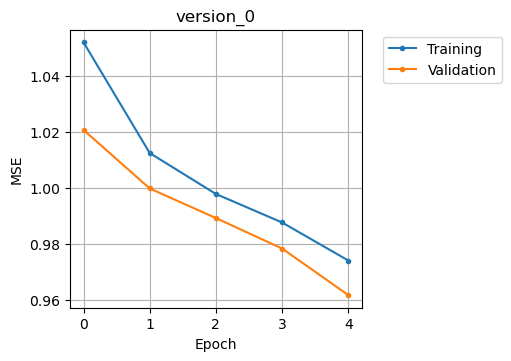

In [698]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
ax.plot(exp0.logs['loss_train'], '.-', label='Training')
ax.plot(exp0.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp0.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Test by regions/seasons

In [710]:
test_dict = exp0.test()
loss_vs_dataset = dict()
for feature in ['sigma0_delta', 'normalized_sigma0_delta'] :
    loss_vs_dataset[feature] = [test_dict[i]['loss_test_'+feature+'/dataloader_idx_'+str(i)] for i in range(len(list_of_datasets))]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:655: UserWarning: Your `test_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_0': 0.9652183651924133,
 'loss_test_sigma0_delta/dataloader_idx_0': 3.6863893910776824e-05}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_1': 0.9593883156776428,
 'loss_test_sigma0_delta/dataloader_idx_1': 7.972083949425723e-06}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_2': 0.9689988493919373,
 'loss_test_sigma0_delta/dataloader_idx_2': 2.3065179988179807e-08}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_3': 0.9734953045845032,
 'loss_test_sigma0_delta/dataloader_idx_3': 2.3116848879567442e-08}
-

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


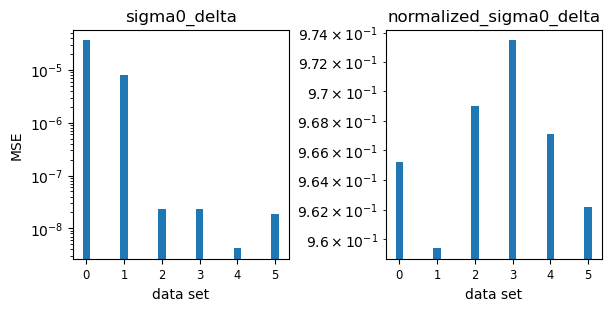

In [720]:
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6, 3))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(list_of_datasets))
bar_width = 0.2

for col, feature in enumerate(['sigma0_delta', 'normalized_sigma0_delta']) :
    ax[col].bar(x, loss_vs_dataset[feature], width=bar_width)
    ax[col].set(title=feature)
for axis in ax :
    axis.set_xlabel('data set')
    axis.xaxis.set_tick_params(labelsize='small')
    axis.set(yscale='log')
ax[0].set(ylabel='MSE')
plt.show()

# Convolutional NN model

In [721]:
class first_CNN(torch.nn.Module):
    def __init__(self, len_keys_input_CNN, len_keys_targets_CNN):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(len_keys_input_CNN, 32, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, padding='same', padding_mode='replicate') 
        self.conv3 = torch.nn.Conv2d(64, len_keys_targets_CNN, kernel_size=3, padding='same', padding_mode='replicate')
        #self.batch_norm1 = nn.BatchNorm2d(32)
        #self.batch_norm2 = nn.BatchNorm2d(64)

    def forward(self, x):
        # conv layer 1
        x = self.conv1(x)
        x = torch.nn.functional.relu(x)
        
        # conv layer 2
        x = self.conv2(x)
        x = torch.nn.functional.relu(x)
        
        # conv layer 5 
        x = self.conv3(x)
        
        return x        

In [722]:
modelCNN = (first_CNN(2,1).double())

In [724]:
class CNN_Model_Class(pl.LightningModule):
    def __init__(self, nnModel, inputs, outputs):
        super().__init__()
        self.nnModel = nnModel
        # for name, param in nnModel.named_parameters():
        #     param.data.normal_(mean=0.0, std=0.1)
        self.inputs = inputs
        self.outputs = outputs
        self.save_hyperparameters()

    def training_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_train', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx) :
        x = self.transform_input(batch)
        y_true = self.transform_target(batch)
        y_model = self.nnModel(x)
        loss = torch.nn.functional.mse_loss(y_model, y_true)  
        self.log('loss_val', loss, on_step=False, on_epoch=True) 
    
    def predict_step(self, batch, batch_idx, dataloader_idx) :        
        x = self.transform_input(batch)
        tensor_model_output = self.nnModel(x)
        pred = dict()
        for i, feature in enumerate(self.outputs) :
            pred[feature] = tensor_model_output[:,i,:,:]
            # if outputs are normalized then compute also result in the restored units (not normalized)
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                pred[not_normalized_feature] = SalinityTemperatureDensityDataset.restore_units(pred[feature], batch, not_normalized_feature)
        return pred
        
    def test_step(self, batch, batch_idx, dataloader_idx) :
        model_output = self.predict_step(batch, batch_idx, dataloader_idx)
        loss = dict()        
        for i, feature in enumerate(self.outputs) : 
            if feature.startswith('normalized_') :
                not_normalized_feature = feature.replace("normalized_", "")
                loss[not_normalized_feature] = eval_loss(model_output[not_normalized_feature], batch[not_normalized_feature])
                self.log('loss_test_'+not_normalized_feature, loss[not_normalized_feature].mean())
            loss[feature] = eval_loss(model_output[feature], batch[feature])
            self.log('loss_test_'+feature, loss[feature].mean())

    def configure_optimizers(self) :
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        #optimizer = torch.optim.SGD(self.parameters(), lr=0.001)
        return optimizer

    def transform_input(self, batch) :
        return torch.transpose(torch.stack([batch[key] for key in self.inputs]), 0, 1)

    def transform_target(self, batch) : 
        return torch.transpose(torch.stack([batch[key] for key in self.outputs]), 0, 1)

In [725]:
# print('Input data for training contains ' + str(len(train_data_loader)) + ' batches, each batch contains ' + str(batch_size) + \
#       ' instanteneous 2D maps of ' +str(len(keys_input_CNN)) + ' channels: ' + str(keys_input_CNN) + ' of size ' + str(h)+'x'+str(w) + ' pixels.')

## Experiment 1

In [726]:
exp1 = Experiment(pl_class=CNN_Model_Class, \
                      model=modelCNN, \
                      label='CNN', \
                      version_name='version_0', \
                      keys_input={'normalized_sosstsst', 'normalized_rho_ct_ct'}, \
                      keys_targets={'normalized_sigma0_delta'}, 
                      datamodule=common_datamodule,
                      max_epochs=5, \
                      limit_train_batches=1.0) 

In [727]:
exp1.keys_input

{'normalized_rho_ct_ct', 'normalized_sosstsst'}

In [728]:
list_c = itertools.combinations({'sigma0_delta','rho_ct_ct', 'sosstsst' }, 2)

In [729]:
for i in list_c :
    print(i[0], i[1])

sosstsst rho_ct_ct
sosstsst sigma0_delta
rho_ct_ct sigma0_delta


In [730]:
exp1.run()
clear_output(wait=True)

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(

  | Name    | Type      | Params
--------------------------------------
0 | nnModel | first_CNN | 19.7 K
--------------------------------------
19.7 K    Trainable params
0         Non-trainable params
19.7 K    Total params
0.079     Total estimated model params size (MB)
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /Users/ana/CODE/Jupyter_Notebooks/oceanDataNotebooks/density_ML/logs/CNN/version_0 exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


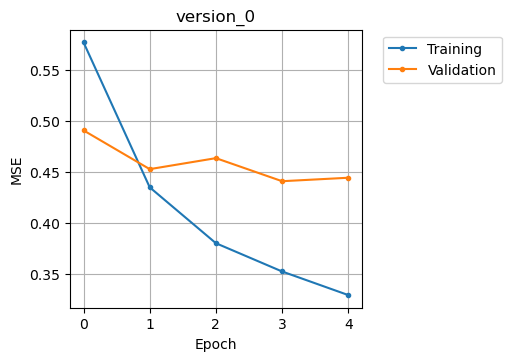

In [731]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(5, 3.5), sharey=True)
ax.plot(exp1.logs['loss_train'], '.-', label='Training')
ax.plot(exp1.logs['loss_val'], '.-', label='Validation')
ax.set(title=exp1.version_name, xlabel='Epoch', ylabel='MSE'); ax.grid(True)
ax.set(ylabel='MSE')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Compare results with deterministic parametrization

## Image example

In [740]:
test_dl = common_datamodule.test_dataloader()[0]

In [741]:
test_dl

In [742]:
best_FCNN_model = LitPixelModel.load_from_checkpoint(exp0.checkpoint_callback.best_model_path)
best_CNN_model = CNN_Model_Class.load_from_checkpoint(exp1.checkpoint_callback.best_model_path)

In [743]:
test_di = iter(test_dl)

In [744]:
sample = next(test_di)

In [745]:
idx = 0 #index inside the batch

In [747]:
snapshot = dict()
snapshot['true_error'] = np.squeeze(sample['normalized_sigma0_delta'][idx])
snapshot['FCNN'] = np.squeeze(best_FCNN_model.predict_step(sample, idx, 0)['normalized_sigma0_delta'][idx].detach().numpy())
snapshot['CNN'] = np.squeeze(best_CNN_model.predict_step(sample, idx, 0)['normalized_sigma0_delta'][idx].detach().numpy())
snapshot['determ_param'] = np.squeeze(SalinityTemperatureDensityDataset.normalize(sample['determ_param_sigma0_delta'], sample, 'sigma0_delta')[idx])

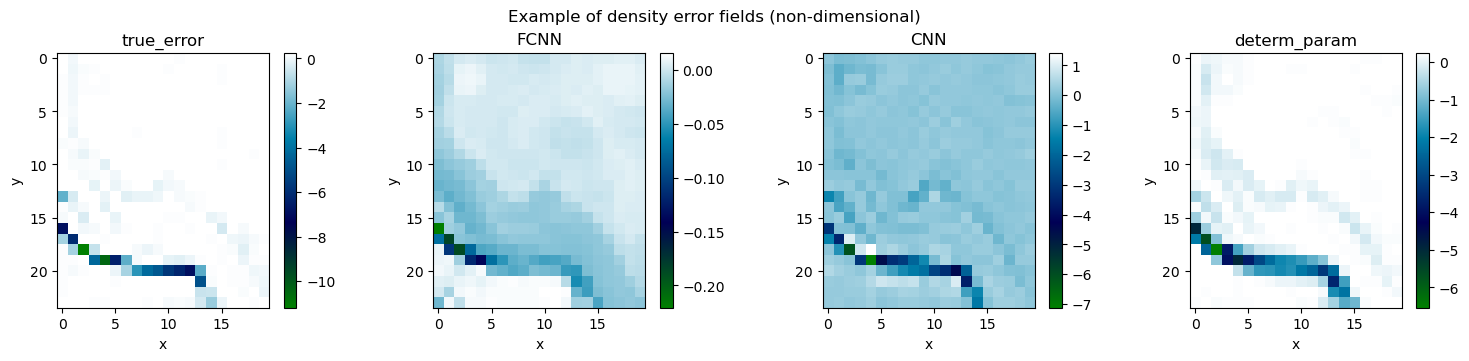

In [750]:
fig, ax = plt.subplots(ncols=len(snapshot.keys()), nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Example of density error fields (non-dimensional)')
for i, key in enumerate(['true_error', 'FCNN', 'CNN', 'determ_param']) :
    
#for i, key in enumerate(['true_error',  'FCNN', 'determ_param']) :
    if i == 0 :
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
    else :
        #img = ax[i].imshow(snapshot[key], cmap='ocean', vmin=color_min, vmax=color_max)
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
    ax[i].set(title=key, xlabel='x', ylabel='y')
plt.show()

In [752]:
snapshot = dict()
snapshot['true_error'] = np.squeeze(sample['sigma0_delta'])
snapshot['FCNN'] = np.squeeze(best_FCNN_model.predict_step(sample, 0,0)['sigma0_delta'].detach().numpy())
snapshot['CNN'] = np.squeeze(best_CNN_model.predict_step(sample, 0,0)['sigma0_delta'].detach().numpy())
snapshot['determ_param'] = np.squeeze(determ_param(sample['diff_T_sqr'], sample['rho_ct_ct'], coef_determ_param))

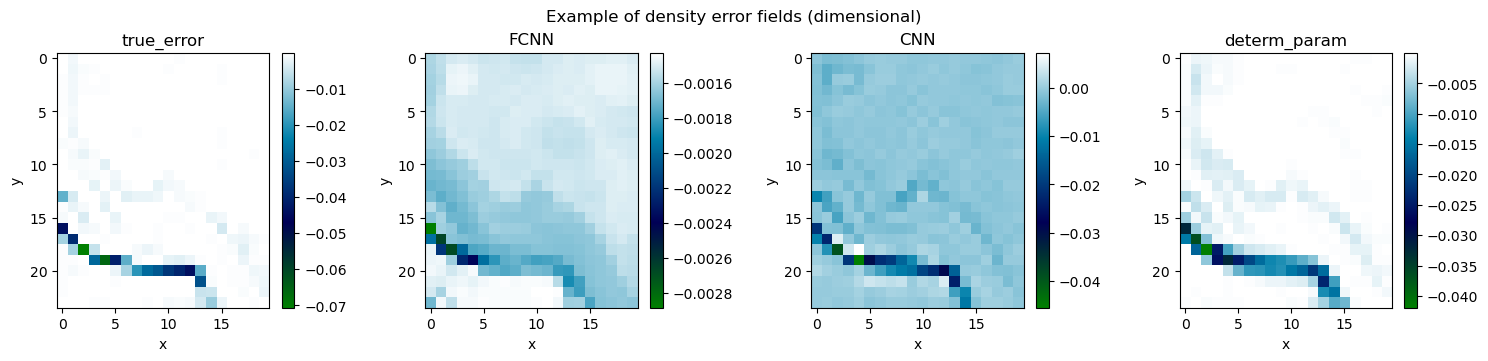

In [754]:
fig, ax = plt.subplots(ncols=len(snapshot.keys()), nrows=1, figsize=(15,3.5), constrained_layout=True)
fig.suptitle('Example of density error fields (dimensional)')
for i, key in enumerate(['true_error', 'FCNN', 'CNN', 'determ_param']) :
    
#for i, key in enumerate(['true_error',  'FCNN', 'determ_param']) :
    if i == 0 :
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
        color_min = img.colorbar.vmin
        color_max = img.colorbar.vmax
    else :
        #img = ax[i].imshow(snapshot[key], cmap='ocean', vmin=color_min, vmax=color_max)
        img = ax[i].imshow(snapshot[key], cmap='ocean')
        fig.colorbar(img, ax=ax[i])
    ax[i].set(title=key, xlabel='x', ylabel='y')
plt.show()

# Evaluation

## Total MSE on a dataset

In [223]:
eval_loss = torch.nn.MSELoss(reduction='none') 

In [224]:
MSE = dict({'determ_param': [], 'FCNN': []})
MSE['determ_param'] = [ list() for i in range(len(list_of_datasets))]
MSE['FCNN' ] = [ list() for i in range(len(list_of_datasets))]
MSE['CNN' ] = [ list() for i in range(len(list_of_datasets))]
labels = ['' for i in range(len(list_of_datasets))]

In [236]:
test_dataloaders = []
for i, dataset_file in enumerate(list_of_datasets) :
    test_dataloaders.append(torch.utils.data.DataLoader(dataset=SalinityTemperatureDensityDataset(list_of_netcdf_files = [dataset_file], \
                                                                         select='First', \
                                                                         portion_of_time_series=0.2, \
                                                                         transform=ToTensor()), \
                                                                         batch_size=1, drop_last=True))
    MSE['determ_param'][i] = 
    torch.nn.MSELoss(determ_param(sample['diff_T_sqr'], sample['rho_ct_ct'], coef_determ_param), sample['sigma0_delta'])
MSE['FCNN'] = [list(test_dict.values())[0] for test_dict in exp0.trainer.test(dataloaders=test_dataloaders, ckpt_path='best')]
MSE['CNN'] = [list(test_dict.values())[0] for test_dict in exp1.trainer.test(dataloaders=test_dataloaders, ckpt_path='best')]

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloader 1, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, test_dataloade

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_0': 0.2688383460044861,
 'loss_test_sigma0_delta/dataloader_idx_0': 1.2066365343343932e-05}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_1': 0.8441644906997681,
 'loss_test_sigma0_delta/dataloader_idx_1': 4.3730083234549966e-06}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_2': 0.5170103907585144,
 'loss_test_sigma0_delta/dataloader_idx_2': 9.149862201240921e-09}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_3': 0.7509809732437134,
 'loss_test_sigma0_delta/dataloader_idx_3': 2.3290349204785343e-08}
-

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_0': 0.11745899170637131,
 'loss_test_sigma0_delta/dataloader_idx_0': 5.27195334143471e-06}
--------------------------------------------------------------------------------
DATALOADER:1 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_1': 0.3522592782974243,
 'loss_test_sigma0_delta/dataloader_idx_1': 1.8248018704980495e-06}
--------------------------------------------------------------------------------
DATALOADER:2 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_2': 0.5441179871559143,
 'loss_test_sigma0_delta/dataloader_idx_2': 9.629602004679327e-09}
--------------------------------------------------------------------------------
DATALOADER:3 TEST RESULTS
{'loss_test_normalized_sigma0_delta/dataloader_idx_3': 0.385276734828949,
 'loss_test_sigma0_delta/dataloader_idx_3': 1.1948674938366821e-08}
---

In [ ]:
%%time
for i in range(len(list_of_datasets)) :
    single_dataset = SalinityTemperatureDensityDataset(list_of_netcdf_files = [list_of_datasets[i]], select='Last', \
                                                 portion_of_time_series=0.2, transform=ToTensor(), normalize=True)
    eval_data_loader = DataLoader(dataset=single_dataset, batch_size=1, shuffle=False)
    current_list_FCNN = []; current_list_CNN = []; current_list_param = []
    for j, sample in enumerate(eval_data_loader) :
        true_error = sample['sigma0_delta']
        FCNN_error = restore_units(sample, modelFCNN(transform_input(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1)
        CNN_error = restore_units(sample, modelCNN(transform_input_CNN(sample)).view(1,w,h),'sigma0_delta',0).view(-1,1)
        determ_param_error = determ_param(restore_units(sample,sample['diff_T_sqr'],'diff_T_sqr',0), \
                                        restore_units(sample,sample['rho_ct_ct'],'rho_ct_ct',0), \
                                        coef_determ_param).view(-1,1).to(torch.float32).to(device)
        current_list_FCNN = current_list_FCNN + list(np.squeeze(eval_loss(FCNN_error, true_error).detach().cpu().numpy()))
        current_list_CNN = current_list_CNN + list(np.squeeze(eval_loss(CNN_error, true_error).detach().cpu().numpy()))
        current_list_param = current_list_param + list(np.squeeze(eval_loss(determ_param_error, true_error).detach().cpu().numpy()))
    MSE['FCNN'][i] = current_list_FCNN
    MSE['CNN'][i] = current_list_CNN
    MSE['determ_param'][i] = current_list_param
    labels[i] = 'Reg ' + sample['dataset_region'][0] + ' ' + sample['dataset_season'][0]

TypeError: SalinityTemperatureDensityDataset.__init__() got an unexpected keyword argument 'normalize'

In [131]:
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(6, 3.5))
#fig.suptitle(r'Spatial correlation coefficient averaged in time: $R(\rho_c, parametrization)$')
x = np.arange(len(list_of_datasets))
bar_width = 0.2

for i, key in enumerate(['determ_param', 'FCNN', 'CNN']) :
    ax.bar(x+i*bar_width, [np.mean(MSE[key][region]) for region in range(len(list_of_datasets))], width=bar_width, label=key)
ax.legend(['Deterministic parametrization', 'Fully connected NN', 'Convolutional NN'])
ax.set_xticks(x+bar_width)
#ax.axhline(y=1., color='k')
ax.set_xticklabels(labels,fontsize=10)
ax.set_xlabel('data set')
ax.xaxis.set_tick_params(labelsize='small')
ax.set(yscale='log')
plt.show()

/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/Caskroom/miniforge/base/envs/new_pytorch/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: Data has no positive values, and therefore can not be log-scaled.

<Figure size 600x350 with 1 Axes>

## Histograms of MSE

In [ ]:
fig, ax = plt.subplots(1, 6, constrained_layout=True, figsize=(15, 3))
fig.suptitle('Histograms of MSE by dataset')
for key in ['determ_param', 'FCNN', 'CNN'] :
    for i in range(len(list_of_datasets)) :
        ax[i].hist(MSE[key][i], bins=30, histtype='step', density=False, label=key)
        ax[i].set(yscale='log', title=labels[i], xlabel='Bins MSE')
ax[0].set(ylabel='counts')
ax[-1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()